<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/4/47/Acronimo_y_nombre_uc3m.png"/>

<img src="https://mirrors.creativecommons.org/presskit/buttons/88x31/png/by-nc-sa.png" width=15%/>
</center>    

# Clasificación de textos con un algoritmo clásico de aprendizaje automático. 

En este notebook, vamos a desarrollar un enfoque basado en un algoritmo clásico de aprendizaje automático. 

El dataset a utilizar es una colección de reviews de Amazon sobre Alexa. Este dataset puede descargarse desde este [link](#https://www.kaggle.com/datasets/sid321axn/amazon-alexa-reviews) en Kaggle. 

El dataset contiene aproximadamente unos 3000 comentarios de clientes sobre Alexa. Cada comentario incluye un rating (de 1 a 5 estrellas) para indicar el grado de satisfacción sobre el producto.


Además de entrenar y evaluar un algoritmo de aprendizaje automático, en concreto Support Vector Machines, también tendremos la oportunidad de prácticar en la representación de textos para la entrada del algoritmo. 



## Cargar un dataset





In [2]:
from google.colab import drive
# mount your google drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/Colab Notebooks/data/alexa/"

Mounted at /content/drive


In [3]:
import pandas as pd

df = pd.read_csv(PATH+"amazon_alexa.tsv",  sep='\t', on_bad_lines='skip') 
print('dataset cargado:', df.shape)

# nos quedamos únicamente con el texto y el campo de rating
df = df[['verified_reviews','rating']] 
# renombramos las columnas
df=df.rename(columns={"verified_reviews": "Text", "rating": "Label"})
df.head()


dataset cargado: (3150, 5)


,Text,Label
0,Love my Echo!,5
1,Loved it!,5
2,"Sometimes while playing a game, you can answer...",4
3,I have had a lot of fun with this thing. My 4 ...,5
4,Music,5


## Crear particiones

El dataset se distribuye en un único fichero. Debemos crear tres particiones distintas para entrenamiento, validación y evaluación final (test), con un ratio de 70:10:20.



In [4]:
from sklearn.model_selection import train_test_split
X=df['Text']
y=df['Label']

X_train, X_aux, y_train, y_aux = train_test_split(X, y, 
        test_size=0.30, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, 
        test_size=2/3, random_state=42, stratify=y_aux)

print('Tamaño conjunto de entrenamiento:', len(X_train))
print('Tamaño conjunto de validación:', len(X_val))
print('Tamaño conjunto de evaluación:', len(X_test))



Tamaño conjunto de entrenamiento: 2205
Tamaño conjunto de validación: 315
Tamaño conjunto de evaluación: 630


## Distribución de clases



In [5]:
counts_train = y_train.value_counts().to_dict()
print("Distribución en training:", counts_train)
counts_val = y_val.value_counts().to_dict()
print("Distribución en validación:", counts_val)
counts_test = y_test.value_counts().to_dict()
print("Distribución en test:", counts_test)

LABELS=counts_train.keys()
print(LABELS)

Distribución en training: {5: 1600, 4: 319, 1: 113, 3: 106, 2: 67}
Distribución en validación: {5: 229, 4: 45, 1: 16, 3: 15, 2: 10}
Distribución en test: {5: 457, 4: 91, 1: 32, 3: 31, 2: 19}
dict_keys([5, 4, 1, 3, 2])


Text(0, 0.5, 'Número de Instancias')

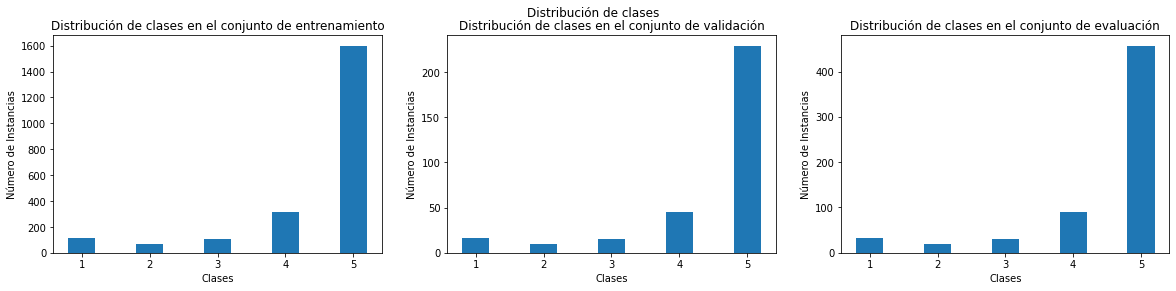

In [6]:
import matplotlib.pyplot as plt

fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Distribución de clases')
ax_train.bar(LABELS, counts_train.values(), width=0.4)
ax_train.set_title('Distribución de clases en el conjunto de entrenamiento')
ax_train.set_xlabel('Clases')
ax_train.set_ylabel('Número de Instancias')

ax_val.bar(LABELS, counts_val.values(), width=0.4)
ax_val.set_title('Distribución de clases en el conjunto de validación')
ax_val.set_xlabel('Clases')
ax_val.set_ylabel('Número de Instancias')


ax_test.bar(LABELS, counts_test.values(), width=0.4)
ax_test.set_title('Distribución de clases en el conjunto de evaluación')
ax_test.set_xlabel('Clases')
ax_test.set_ylabel('Número de Instancias')

## Distribución del tamaño de los textos


In [7]:
length_train=X_train.apply(lambda text: len(text.split()))
length_train.describe()

count    2205.000000
mean       26.170522
std        36.618675
min         0.000000
25%         6.000000
50%        15.000000
75%        32.000000
max       526.000000
Name: Text, dtype: float64

In [8]:
length_train.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    2205.000000
mean       26.170522
std        36.618675
min         0.000000
25%         6.000000
50%        15.000000
75%        32.000000
90%        60.000000
95%        86.800000
99%       171.000000
max       526.000000
Name: Text, dtype: float64

In [9]:
length_val=X_val.apply(lambda text: len(text.split()))
length_val.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    315.000000
mean      21.320635
std       25.860762
min        0.000000
25%        6.000000
50%       13.000000
75%       26.000000
90%       49.000000
95%       63.000000
99%      125.580000
max      177.000000
Name: Text, dtype: float64

In [10]:
length_test=X_test.apply(lambda text: len(text.split()))
length_test.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    630.000000
mean      24.207937
std       30.724473
min        0.000000
25%        5.000000
50%       12.000000
75%       30.000000
90%       64.000000
95%       89.550000
99%      132.420000
max      278.000000
Name: Text, dtype: float64

Text(0, 0.5, 'Número de textos')

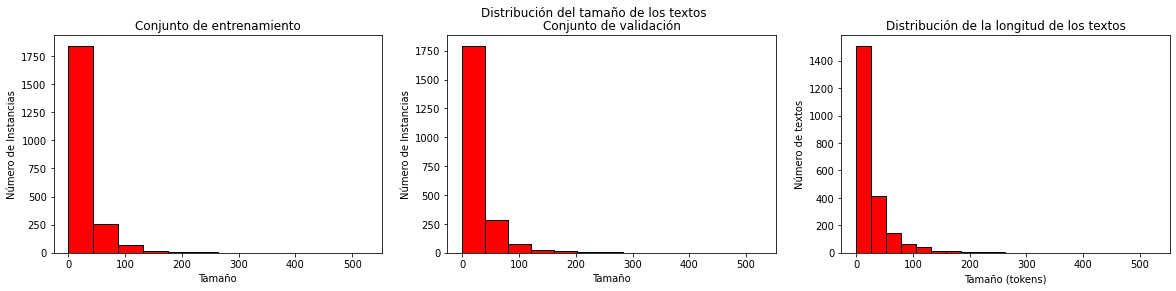

In [11]:
import matplotlib.pyplot as plt

fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Distribución del tamaño de los textos')

ax_train.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(600/50))
ax_train.set_title('Conjunto de entrenamiento')
ax_train.set_xlabel('Tamaño')
ax_train.set_ylabel('Número de Instancias')

ax_val.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(200/15))
ax_val.set_title('Conjunto de validación')
ax_val.set_xlabel('Tamaño')
ax_val.set_ylabel('Número de Instancias')

ax_test.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(300/15))
ax_test.set_title('Conjunto test')
ax_test.set_xlabel('Tamaño')
ax_test.set_ylabel('Número de Instancias')

# Add labels
plt.title('Distribución de la longitud de los textos')
plt.xlabel('Tamaño (tokens)')
plt.ylabel('Número de textos')

Gracias a los tres gráficos, podemos afirmar que la distribución de las clases es similar en los tres subconjuntos de datos. 

## Representación de textos
La entrada de nuestro algoritmo de clasificación son los textos, pero estos deben ser representados como vectores de números reales.

Antes de realizar esta transformación, también vamos a incluir algunas tareas que nos permiten limpiar los textos eliminando palabras y símbolos que no aporten información semántica para la clasificación de los textos:



In [12]:
import nltk

nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
stopwords_en = stopwords.words("english")

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re


def clean_text(text):
    # transformar a minúscula
    text=str(text).lower()
    # tokenizar
    tokens=word_tokenize(text)
    # borrar stopwords
    tokens = [word for word in tokens if word not in stopwords_en]
    # usar los stems
    tokens = [PorterStemmer().stem(word) for word in tokens]
    # eliminamos las palabras con menos de 3 caráceres
    # ignoramos cualquier palabra que contenga un digito o un símbolo especial 
    min_length = 3
    p = re.compile('^[a-zA-Z]+$');
    filtered_tokens=[]
    for token in tokens:
        if len(token)>=min_length and p.match(token):
            filtered_tokens.append(token)
            
    return filtered_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### tf-idf

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# entrenamos un modelo de bolsa de palabras
bow = CountVectorizer(analyzer=clean_text).fit(X_train)
# transformamos el conjunto de entrenamiento a bolsa de palabras
X_train_bow = bow.transform(X_train)
# transformamos el conjunto de evaluación a bolsa de palabras
X_test_bow=bow.transform(X_test)


# entrenamos un modelo tf-idf 
tfidf_transformer = TfidfTransformer().fit(X_train_bow)
# transformamos el conjunto de entrenamiento
X_train_tfidf = tfidf_transformer.transform(X_train_bow)
# transformamos el conjunto de entrenamiento
X_test_tfidf = tfidf_transformer.transform(X_test_bow)

print('textos han sido representados con el modelo tf-idf ')

textos han sido representados con el modelo tf-idf 


In [24]:
print(X_train[1])
print(X_train_bow[1])
print(X_train_tfidf[1])

Loved it!
  (0, 134)	1
  (0, 401)	1
  (0, 641)	1
  (0, 760)	1
  (0, 892)	1
  (0, 969)	1
  (0, 984)	1
  (0, 1172)	1
  (0, 1318)	1
  (0, 1511)	1
  (0, 1605)	1
  (0, 1621)	1
  (0, 1745)	1
  (0, 2074)	1
  (0, 2150)	1
  (0, 2231)	1
  (0, 2231)	0.24848569048728514
  (0, 2150)	0.25073011141503715
  (0, 2074)	0.2943438793750151
  (0, 1745)	0.24848569048728514
  (0, 1621)	0.39526593882219163
  (0, 1605)	0.2644613840321938
  (0, 1511)	0.19844781431205044
  (0, 1318)	0.1687887849138693
  (0, 1172)	0.23903893603876666
  (0, 984)	0.25386653457291786
  (0, 969)	0.21751925506588043
  (0, 892)	0.14607394870368387
  (0, 760)	0.30316521341041
  (0, 641)	0.14896409999940147
  (0, 401)	0.2739330136813633
  (0, 134)	0.23147535369228014


## Clasificación

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# definimos un pipeline que primero transforma los textos a BoW
# después los textos se transforma en formato tfidf
# finalmente, se aplica el algoritmo
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  
    ('tf', TfidfTransformer()),  
    ('svm', SVC()), 
])

#pipeline.fit(X_train, y_train)


# Parámetros para el algoritmo SVM
grid_params_svm = [{'svm__kernel': ['linear', 'rbf'], 
                    'svm__C': [0.1, 1], # [0.1, 1, 10, 100, 1000]
                    # 'svm__gamma':  [1, 0.1, 0.01, 0.001, 0.0001]
                    }]  

  
gs = GridSearchCV(pipeline, param_grid=grid_params_svm, 
                  scoring='accuracy', cv=3, verbose = 1)

# entrenamos el grid
gs.fit(X_train, y_train)
print('Los mejores parámetros son : %s' % gs.best_params_)
print('Mejor accuracy: %.3f' % gs.best_score_)
print(gs.best_estimator_)



Fitting 3 folds for each of 4 candidates, totalling 12 fits
Los mejores parámetros son : {'svm__C': 1, 'svm__kernel': 'rbf'}


In [35]:
predictions = gs.predict(X_test)

In [36]:
from sklearn.metrics import classification_report
print( classification_report(y_test, predictions))

              precision    recall  f1-score   support

           1       1.00      0.16      0.27        32
           2       1.00      0.05      0.10        19
           3       1.00      0.35      0.52        31
           4       1.00      0.21      0.35        91
           5       0.77      1.00      0.87       457

    accuracy                           0.78       630
   macro avg       0.95      0.35      0.42       630
weighted avg       0.83      0.78      0.72       630



## Ejercicio:

Prueba con los siguientes algoritmos:
- Logistic Regression. Probar con distintos parámetros:
    - penalty': ['l1', 'l2']
    - C: [1.0, 0.5]
    - solver: ['liblinear']
- RandomForestClassifier. Probar con distintos parámetros:
    - criterion: ['gini', 'entropy'],
    - max_depth: [9, 10],
    - min_samples_split': [10]

¿Cuál es el mejor enfoque?
